# Check the Python version being used

In [1]:
!python --version

Python 3.7.6


# Check that the available gpu is being utilized

In [2]:
import tensorflow as tf

In [3]:
print("Num GPUs Available")
print(len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available
1


# Start of second method of lstm time series forecasting

In [4]:
from pandas import read_csv

df = read_csv('Time_Series_For_Clustering_El_Paso_Final.csv')

# get each separate time series as an individual list and append each of these lists to a master list

In [5]:
import re
import pandas as pd

non_decimal = re.compile(r'[^\d.]+')

list_of_training_df = []
list_of_row_components = []

for i in range(1, 524):
    
    current_row = df.iloc[i]
    
    bridge_id = current_row.iloc[0]
    
    current_row = current_row.iloc[1:]
    
    for j, row in current_row.iteritems():
        
        current_row_components = row.split(', ')
        current_row_components_replaced = []

        for idx, component in enumerate(current_row_components):

            result = non_decimal.sub('', current_row_components[idx])
            current_row_components_replaced.append(float(result))

        list_of_row_components.append(current_row_components_replaced)

# Ensure each element in the list of lists is a float

In [6]:
for idx, element in enumerate(list_of_row_components):
    for i in range(1, len(element)):
        list_of_row_components[idx][i] = float(list_of_row_components[idx][i])

# View one time series

In [7]:
for i in range(22):
    print(list_of_row_components[i])

[36.0, 97.0, 428.0, 1949.0, 2.0, 10.9, 7.3]
[36.0, 96.9, 955.0, 1949.0, 2.0, 10.9, 7.3]
[36.0, 96.9, 955.0, 1949.0, 2.0, 10.9, 7.3]
[36.0, 96.9, 955.0, 1949.0, 2.0, 10.9, 7.3]
[36.0, 96.9, 955.0, 1949.0, 2.0, 10.9, 7.3]
[36.3, 97.0, 955.0, 1949.0, 2.0, 11.0, 7.0]
[36.3, 96.9, 955.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 96.9, 983.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 96.9, 983.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 96.9, 983.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 96.9, 983.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 97.0, 422.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 97.0, 422.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 97.0, 422.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 97.0, 422.0, 1949.0, 2.0, 11.0, 7.3]
[36.3, 97.0, 422.0, 1949.0, 2.0, 9.7, 7.3]
[36.3, 97.0, 369.0, 1949.0, 2.0, 9.7, 7.3]
[36.3, 86.0, 369.0, 1949.0, 2.0, 9.7, 7.3]
[36.3, 86.0, 369.0, 1949.0, 2.0, 9.7, 7.3]
[36.3, 86.0, 369.0, 1949.0, 2.0, 9.7, 7.3]
[36.3, 86.0, 369.0, 1949.0, 2.0, 9.7, 7.3]
[36.3, 86.0, 522.0, 1949.0, 2.0, 9.7, 7.3]


# Get length of list of lists

In [8]:
len(list_of_row_components)

11506

# Swap last entry with second entry in time series to make the output predictor variable Sufficiency Rating

In [9]:
for idx, component in enumerate(list_of_row_components):
    temp = component[6]
    list_of_row_components[idx][6] = list_of_row_components[idx][1]
    list_of_row_components[idx][1] = temp

# Convert format of list to have a single time series for each index

In [10]:
import numpy as np

list_of_examples = []
temp_list = []

max_num = 22
iter = 0;

for row_component in list_of_row_components:
    if iter == max_num:
        list_of_examples.append(np.array(temp_list))
        temp_list = []
        iter = 0
        
    temp_list.append(np.array(row_component))
    iter += 1

list_of_examples = np.array(list_of_examples)

# Make the very last time step of each time series just a single value (Sufficiency Rating) for the model to predict on

In [11]:
for idx, example in enumerate(list_of_examples):
    list_of_examples[idx][21] = [list_of_examples[idx][21][6]]

In [12]:
list_of_examples.shape

(522, 22, 7)

# Perform train test split for dataset

In [13]:
from sklearn.model_selection import train_test_split

n_train_periods = 300
train = list_of_examples[:n_train_periods, :]
test = list_of_examples[n_train_periods:, :]

# split into input and outputs
train_X, train_y = train[:, :-1, 1:], train[:, -1, 0]
test_X, test_y = test[:, :-1, 1:], test[:, -1, 0]


In [14]:
print("Shape of train_X: " + str(train_X.shape))
print("Shape of train_y: " + str(train_y.shape))
print("Shape of test_X: " + str(test_X.shape))
print("Shape of test_y: " + str(test_y.shape))

Shape of train_X: (300, 21, 6)
Shape of train_y: (300,)
Shape of test_X: (222, 21, 6)
Shape of test_y: (222,)


# Build cnn model

In [15]:
cnn_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, input_shape=(train_X.shape[1],train_X.shape[2])),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(units=10),
    tf.keras.layers.Dense(units=1)
])

# Compile model

In [16]:
from tensorflow import keras

cnn_model.compile(loss='mae', optimizer='adam')

# Train model

In [17]:
history = cnn_model.fit(train_X, train_y, epochs=2000, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/2000
10/10 - 0s - loss: 602.4415 - val_loss: 2293.0210
Epoch 2/2000
10/10 - 0s - loss: 507.4201 - val_loss: 1960.3368
Epoch 3/2000
10/10 - 0s - loss: 382.4624 - val_loss: 763.3524
Epoch 4/2000
10/10 - 0s - loss: 239.9385 - val_loss: 863.8848
Epoch 5/2000
10/10 - 0s - loss: 180.2776 - val_loss: 733.6503
Epoch 6/2000
10/10 - 0s - loss: 208.8945 - val_loss: 723.3716
Epoch 7/2000
10/10 - 0s - loss: 173.3118 - val_loss: 390.5252
Epoch 8/2000
10/10 - 0s - loss: 216.4989 - val_loss: 721.9170
Epoch 9/2000
10/10 - 0s - loss: 169.2380 - val_loss: 553.1757
Epoch 10/2000
10/10 - 0s - loss: 217.0925 - val_loss: 767.7449
Epoch 11/2000
10/10 - 0s - loss: 161.6736 - val_loss: 656.3588
Epoch 12/2000
10/10 - 0s - loss: 212.9948 - val_loss: 771.5919
Epoch 13/2000
10/10 - 0s - loss: 155.0854 - val_loss: 630.1773
Epoch 14/2000
10/10 - 0s - loss: 202.2240 - val_loss: 743.1569
Epoch 15/2000
10/10 - 0s - loss: 149.2867 - val_loss: 589.1254
Epoch 16/2000
10/10 - 0s - loss: 189.2115 - val_loss: 612.7487

10/10 - 0s - loss: 78.5971 - val_loss: 124.3643
Epoch 133/2000
10/10 - 0s - loss: 61.7495 - val_loss: 200.9643
Epoch 134/2000
10/10 - 0s - loss: 91.9863 - val_loss: 139.9534
Epoch 135/2000
10/10 - 0s - loss: 33.4806 - val_loss: 114.5168
Epoch 136/2000
10/10 - 0s - loss: 39.7208 - val_loss: 123.6635
Epoch 137/2000
10/10 - 0s - loss: 65.6538 - val_loss: 125.4627
Epoch 138/2000
10/10 - 0s - loss: 34.5723 - val_loss: 165.2335
Epoch 139/2000
10/10 - 0s - loss: 56.4904 - val_loss: 212.6697
Epoch 140/2000
10/10 - 0s - loss: 68.3541 - val_loss: 236.2452
Epoch 141/2000
10/10 - 0s - loss: 93.9406 - val_loss: 127.5422
Epoch 142/2000
10/10 - 0s - loss: 34.7930 - val_loss: 101.5874
Epoch 143/2000
10/10 - 0s - loss: 27.1077 - val_loss: 141.0296
Epoch 144/2000
10/10 - 0s - loss: 60.0466 - val_loss: 209.2860
Epoch 145/2000
10/10 - 0s - loss: 67.3447 - val_loss: 105.5116
Epoch 146/2000
10/10 - 0s - loss: 56.6622 - val_loss: 203.2982
Epoch 147/2000
10/10 - 0s - loss: 76.5226 - val_loss: 351.0724
Epoch 1

Epoch 263/2000
10/10 - 0s - loss: 44.6412 - val_loss: 131.8461
Epoch 264/2000
10/10 - 0s - loss: 49.7500 - val_loss: 127.3343
Epoch 265/2000
10/10 - 0s - loss: 44.6211 - val_loss: 111.6453
Epoch 266/2000
10/10 - 0s - loss: 35.8231 - val_loss: 143.9314
Epoch 267/2000
10/10 - 0s - loss: 62.2999 - val_loss: 100.0466
Epoch 268/2000
10/10 - 0s - loss: 37.9550 - val_loss: 170.6537
Epoch 269/2000
10/10 - 0s - loss: 41.7835 - val_loss: 110.2418
Epoch 270/2000
10/10 - 0s - loss: 47.4471 - val_loss: 65.5072
Epoch 271/2000
10/10 - 0s - loss: 17.1162 - val_loss: 85.1841
Epoch 272/2000
10/10 - 0s - loss: 44.1940 - val_loss: 142.5388
Epoch 273/2000
10/10 - 0s - loss: 37.3159 - val_loss: 69.5818
Epoch 274/2000
10/10 - 0s - loss: 44.6298 - val_loss: 120.3584
Epoch 275/2000
10/10 - 0s - loss: 45.0883 - val_loss: 80.1530
Epoch 276/2000
10/10 - 0s - loss: 41.0010 - val_loss: 98.3768
Epoch 277/2000
10/10 - 0s - loss: 21.8510 - val_loss: 92.1949
Epoch 278/2000
10/10 - 0s - loss: 39.4041 - val_loss: 129.099

Epoch 395/2000
10/10 - 0s - loss: 15.6705 - val_loss: 56.9173
Epoch 396/2000
10/10 - 0s - loss: 30.3308 - val_loss: 100.0190
Epoch 397/2000
10/10 - 0s - loss: 25.5245 - val_loss: 52.5803
Epoch 398/2000
10/10 - 0s - loss: 34.8483 - val_loss: 94.7824
Epoch 399/2000
10/10 - 0s - loss: 35.4332 - val_loss: 77.1871
Epoch 400/2000
10/10 - 0s - loss: 32.0215 - val_loss: 54.2750
Epoch 401/2000
10/10 - 0s - loss: 13.1036 - val_loss: 67.5762
Epoch 402/2000
10/10 - 0s - loss: 19.8844 - val_loss: 45.5549
Epoch 403/2000
10/10 - 0s - loss: 31.7739 - val_loss: 59.0046
Epoch 404/2000
10/10 - 0s - loss: 17.3003 - val_loss: 47.0875
Epoch 405/2000
10/10 - 0s - loss: 31.1557 - val_loss: 82.6410
Epoch 406/2000
10/10 - 0s - loss: 30.6830 - val_loss: 95.3692
Epoch 407/2000
10/10 - 0s - loss: 35.2033 - val_loss: 71.2129
Epoch 408/2000
10/10 - 0s - loss: 19.2467 - val_loss: 87.1651
Epoch 409/2000
10/10 - 0s - loss: 32.1372 - val_loss: 67.1581
Epoch 410/2000
10/10 - 0s - loss: 15.5727 - val_loss: 67.3734
Epoch 4

Epoch 527/2000
10/10 - 0s - loss: 21.7940 - val_loss: 52.2441
Epoch 528/2000
10/10 - 0s - loss: 28.6375 - val_loss: 40.9191
Epoch 529/2000
10/10 - 0s - loss: 22.0753 - val_loss: 67.3388
Epoch 530/2000
10/10 - 0s - loss: 21.3481 - val_loss: 73.9833
Epoch 531/2000
10/10 - 0s - loss: 23.9715 - val_loss: 40.9541
Epoch 532/2000
10/10 - 0s - loss: 27.2399 - val_loss: 44.4562
Epoch 533/2000
10/10 - 0s - loss: 21.3843 - val_loss: 72.3826
Epoch 534/2000
10/10 - 0s - loss: 21.1579 - val_loss: 47.9455
Epoch 535/2000
10/10 - 0s - loss: 26.2132 - val_loss: 79.4138
Epoch 536/2000
10/10 - 0s - loss: 27.2763 - val_loss: 148.4280
Epoch 537/2000
10/10 - 0s - loss: 22.1044 - val_loss: 37.4907
Epoch 538/2000
10/10 - 0s - loss: 19.6110 - val_loss: 58.0994
Epoch 539/2000
10/10 - 0s - loss: 30.9370 - val_loss: 51.7703
Epoch 540/2000
10/10 - 0s - loss: 11.5768 - val_loss: 52.3521
Epoch 541/2000
10/10 - 0s - loss: 15.5857 - val_loss: 37.5345
Epoch 542/2000
10/10 - 0s - loss: 24.6073 - val_loss: 78.3356
Epoch 5

Epoch 659/2000
10/10 - 0s - loss: 25.5203 - val_loss: 102.1599
Epoch 660/2000
10/10 - 0s - loss: 26.0799 - val_loss: 112.4095
Epoch 661/2000
10/10 - 0s - loss: 24.0660 - val_loss: 104.2321
Epoch 662/2000
10/10 - 0s - loss: 26.7154 - val_loss: 123.8217
Epoch 663/2000
10/10 - 0s - loss: 25.5561 - val_loss: 91.5917
Epoch 664/2000
10/10 - 0s - loss: 24.1700 - val_loss: 105.6285
Epoch 665/2000
10/10 - 0s - loss: 23.1832 - val_loss: 104.4084
Epoch 666/2000
10/10 - 0s - loss: 26.4793 - val_loss: 120.9592
Epoch 667/2000
10/10 - 0s - loss: 25.0382 - val_loss: 85.0198
Epoch 668/2000
10/10 - 0s - loss: 22.8673 - val_loss: 99.1783
Epoch 669/2000
10/10 - 0s - loss: 21.6266 - val_loss: 92.1866
Epoch 670/2000
10/10 - 0s - loss: 23.6717 - val_loss: 107.2539
Epoch 671/2000
10/10 - 0s - loss: 22.8280 - val_loss: 92.6865
Epoch 672/2000
10/10 - 0s - loss: 24.0789 - val_loss: 104.0606
Epoch 673/2000
10/10 - 0s - loss: 22.7210 - val_loss: 92.7631
Epoch 674/2000
10/10 - 0s - loss: 23.8129 - val_loss: 101.562

Epoch 791/2000
10/10 - 0s - loss: 14.1252 - val_loss: 43.9656
Epoch 792/2000
10/10 - 0s - loss: 14.9439 - val_loss: 54.0259
Epoch 793/2000
10/10 - 0s - loss: 14.6731 - val_loss: 39.8754
Epoch 794/2000
10/10 - 0s - loss: 14.3003 - val_loss: 46.5591
Epoch 795/2000
10/10 - 0s - loss: 13.4639 - val_loss: 35.6233
Epoch 796/2000
10/10 - 0s - loss: 13.6463 - val_loss: 50.9639
Epoch 797/2000
10/10 - 0s - loss: 14.1036 - val_loss: 41.3363
Epoch 798/2000
10/10 - 0s - loss: 14.7011 - val_loss: 52.1603
Epoch 799/2000
10/10 - 0s - loss: 14.4961 - val_loss: 37.4186
Epoch 800/2000
10/10 - 0s - loss: 13.9130 - val_loss: 47.1710
Epoch 801/2000
10/10 - 0s - loss: 13.6689 - val_loss: 40.9524
Epoch 802/2000
10/10 - 0s - loss: 14.5782 - val_loss: 51.7328
Epoch 803/2000
10/10 - 0s - loss: 14.4511 - val_loss: 36.9987
Epoch 804/2000
10/10 - 0s - loss: 13.8205 - val_loss: 45.2621
Epoch 805/2000
10/10 - 0s - loss: 13.2458 - val_loss: 33.9527
Epoch 806/2000
10/10 - 0s - loss: 13.3221 - val_loss: 47.2513
Epoch 80

10/10 - 0s - loss: 11.4119 - val_loss: 24.0935
Epoch 924/2000
10/10 - 0s - loss: 11.6184 - val_loss: 39.2221
Epoch 925/2000
10/10 - 0s - loss: 11.8661 - val_loss: 27.1971
Epoch 926/2000
10/10 - 0s - loss: 11.7675 - val_loss: 33.1213
Epoch 927/2000
10/10 - 0s - loss: 11.1985 - val_loss: 19.9817
Epoch 928/2000
10/10 - 0s - loss: 10.7547 - val_loss: 31.8837
Epoch 929/2000
10/10 - 0s - loss: 10.8359 - val_loss: 23.0901
Epoch 930/2000
10/10 - 0s - loss: 11.4449 - val_loss: 35.1641
Epoch 931/2000
10/10 - 0s - loss: 11.3957 - val_loss: 24.4814
Epoch 932/2000
10/10 - 0s - loss: 11.6311 - val_loss: 36.3321
Epoch 933/2000
10/10 - 0s - loss: 11.5520 - val_loss: 24.9606
Epoch 934/2000
10/10 - 0s - loss: 11.6238 - val_loss: 36.8588
Epoch 935/2000
10/10 - 0s - loss: 11.6700 - val_loss: 24.6299
Epoch 936/2000
10/10 - 0s - loss: 11.5894 - val_loss: 36.5010
Epoch 937/2000
10/10 - 0s - loss: 11.7570 - val_loss: 28.3148
Epoch 938/2000
10/10 - 0s - loss: 11.8306 - val_loss: 35.2859
Epoch 939/2000
10/10 - 

Epoch 1056/2000
10/10 - 0s - loss: 8.1893 - val_loss: 12.0179
Epoch 1057/2000
10/10 - 0s - loss: 7.5731 - val_loss: 9.5050
Epoch 1058/2000
10/10 - 0s - loss: 8.8350 - val_loss: 20.5458
Epoch 1059/2000
10/10 - 0s - loss: 8.1614 - val_loss: 9.9553
Epoch 1060/2000
10/10 - 0s - loss: 9.2612 - val_loss: 20.3731
Epoch 1061/2000
10/10 - 0s - loss: 7.8876 - val_loss: 9.2664
Epoch 1062/2000
10/10 - 0s - loss: 8.1502 - val_loss: 21.7119
Epoch 1063/2000
10/10 - 0s - loss: 6.9196 - val_loss: 14.5505
Epoch 1064/2000
10/10 - 0s - loss: 7.4737 - val_loss: 29.2368
Epoch 1065/2000
10/10 - 0s - loss: 8.3685 - val_loss: 13.2462
Epoch 1066/2000
10/10 - 0s - loss: 9.2364 - val_loss: 12.6366
Epoch 1067/2000
10/10 - 0s - loss: 9.9162 - val_loss: 32.5308
Epoch 1068/2000
10/10 - 0s - loss: 9.9219 - val_loss: 30.8918
Epoch 1069/2000
10/10 - 0s - loss: 10.4437 - val_loss: 35.5638
Epoch 1070/2000
10/10 - 0s - loss: 9.7533 - val_loss: 13.9526
Epoch 1071/2000
10/10 - 0s - loss: 11.2822 - val_loss: 9.4545
Epoch 1072

Epoch 1189/2000
10/10 - 0s - loss: 9.2092 - val_loss: 10.5650
Epoch 1190/2000
10/10 - 0s - loss: 5.6111 - val_loss: 11.5288
Epoch 1191/2000
10/10 - 0s - loss: 6.4761 - val_loss: 16.6185
Epoch 1192/2000
10/10 - 0s - loss: 8.2080 - val_loss: 13.0644
Epoch 1193/2000
10/10 - 0s - loss: 6.5976 - val_loss: 8.1498
Epoch 1194/2000
10/10 - 0s - loss: 8.2076 - val_loss: 19.5813
Epoch 1195/2000
10/10 - 0s - loss: 7.6703 - val_loss: 11.6564
Epoch 1196/2000
10/10 - 0s - loss: 7.9623 - val_loss: 21.9917
Epoch 1197/2000
10/10 - 0s - loss: 7.2503 - val_loss: 7.2114
Epoch 1198/2000
10/10 - 0s - loss: 7.7914 - val_loss: 11.8970
Epoch 1199/2000
10/10 - 0s - loss: 7.4265 - val_loss: 10.5153
Epoch 1200/2000
10/10 - 0s - loss: 5.8203 - val_loss: 7.8927
Epoch 1201/2000
10/10 - 0s - loss: 5.4834 - val_loss: 10.8309
Epoch 1202/2000
10/10 - 0s - loss: 5.7343 - val_loss: 8.3261
Epoch 1203/2000
10/10 - 0s - loss: 7.5872 - val_loss: 9.4370
Epoch 1204/2000
10/10 - 0s - loss: 5.2848 - val_loss: 12.7451
Epoch 1205/20

10/10 - 0s - loss: 8.0903 - val_loss: 9.4058
Epoch 1323/2000
10/10 - 0s - loss: 6.8378 - val_loss: 13.1473
Epoch 1324/2000
10/10 - 0s - loss: 7.3339 - val_loss: 14.2101
Epoch 1325/2000
10/10 - 0s - loss: 7.4866 - val_loss: 26.4203
Epoch 1326/2000
10/10 - 0s - loss: 6.8712 - val_loss: 12.3567
Epoch 1327/2000
10/10 - 0s - loss: 7.4679 - val_loss: 13.2613
Epoch 1328/2000
10/10 - 0s - loss: 6.8596 - val_loss: 11.9968
Epoch 1329/2000
10/10 - 0s - loss: 6.7217 - val_loss: 7.2053
Epoch 1330/2000
10/10 - 0s - loss: 7.1014 - val_loss: 9.9736
Epoch 1331/2000
10/10 - 0s - loss: 6.5528 - val_loss: 11.3209
Epoch 1332/2000
10/10 - 0s - loss: 7.5124 - val_loss: 9.9221
Epoch 1333/2000
10/10 - 0s - loss: 7.2546 - val_loss: 7.3759
Epoch 1334/2000
10/10 - 0s - loss: 7.6888 - val_loss: 21.2747
Epoch 1335/2000
10/10 - 0s - loss: 6.4905 - val_loss: 8.6147
Epoch 1336/2000
10/10 - 0s - loss: 6.8587 - val_loss: 12.1914
Epoch 1337/2000
10/10 - 0s - loss: 6.5415 - val_loss: 7.9564
Epoch 1338/2000
10/10 - 0s - lo

Epoch 1456/2000
10/10 - 0s - loss: 5.2383 - val_loss: 8.1829
Epoch 1457/2000
10/10 - 0s - loss: 4.8428 - val_loss: 9.9732
Epoch 1458/2000
10/10 - 0s - loss: 5.6222 - val_loss: 6.6057
Epoch 1459/2000
10/10 - 0s - loss: 4.5446 - val_loss: 8.4684
Epoch 1460/2000
10/10 - 0s - loss: 6.9144 - val_loss: 7.9057
Epoch 1461/2000
10/10 - 0s - loss: 5.5433 - val_loss: 6.4539
Epoch 1462/2000
10/10 - 0s - loss: 7.2855 - val_loss: 8.4116
Epoch 1463/2000
10/10 - 0s - loss: 6.6387 - val_loss: 22.1104
Epoch 1464/2000
10/10 - 0s - loss: 6.7301 - val_loss: 19.6610
Epoch 1465/2000
10/10 - 0s - loss: 7.6218 - val_loss: 18.8318
Epoch 1466/2000
10/10 - 0s - loss: 7.4247 - val_loss: 8.8489
Epoch 1467/2000
10/10 - 0s - loss: 9.3271 - val_loss: 15.2117
Epoch 1468/2000
10/10 - 0s - loss: 7.5837 - val_loss: 31.1875
Epoch 1469/2000
10/10 - 0s - loss: 6.8022 - val_loss: 17.9510
Epoch 1470/2000
10/10 - 0s - loss: 8.8462 - val_loss: 12.8243
Epoch 1471/2000
10/10 - 0s - loss: 7.8761 - val_loss: 10.4754
Epoch 1472/2000


Epoch 1590/2000
10/10 - 0s - loss: 6.4071 - val_loss: 8.6463
Epoch 1591/2000
10/10 - 0s - loss: 7.9734 - val_loss: 7.7104
Epoch 1592/2000
10/10 - 0s - loss: 5.6626 - val_loss: 8.7886
Epoch 1593/2000
10/10 - 0s - loss: 6.1042 - val_loss: 15.1051
Epoch 1594/2000
10/10 - 0s - loss: 5.8989 - val_loss: 11.2698
Epoch 1595/2000
10/10 - 0s - loss: 6.0607 - val_loss: 13.9636
Epoch 1596/2000
10/10 - 0s - loss: 5.9223 - val_loss: 6.4266
Epoch 1597/2000
10/10 - 0s - loss: 5.4539 - val_loss: 7.6939
Epoch 1598/2000
10/10 - 0s - loss: 6.2182 - val_loss: 5.4201
Epoch 1599/2000
10/10 - 0s - loss: 4.7090 - val_loss: 11.2660
Epoch 1600/2000
10/10 - 0s - loss: 5.0995 - val_loss: 7.8945
Epoch 1601/2000
10/10 - 0s - loss: 6.5135 - val_loss: 9.9727
Epoch 1602/2000
10/10 - 0s - loss: 6.9771 - val_loss: 18.8998
Epoch 1603/2000
10/10 - 0s - loss: 6.4938 - val_loss: 19.5525
Epoch 1604/2000
10/10 - 0s - loss: 7.0223 - val_loss: 16.0384
Epoch 1605/2000
10/10 - 0s - loss: 6.4365 - val_loss: 8.5492
Epoch 1606/2000
1

Epoch 1724/2000
10/10 - 0s - loss: 5.1710 - val_loss: 5.4640
Epoch 1725/2000
10/10 - 0s - loss: 5.4822 - val_loss: 9.1575
Epoch 1726/2000
10/10 - 0s - loss: 5.3672 - val_loss: 5.8471
Epoch 1727/2000
10/10 - 0s - loss: 5.7611 - val_loss: 15.9106
Epoch 1728/2000
10/10 - 0s - loss: 5.6640 - val_loss: 12.2494
Epoch 1729/2000
10/10 - 0s - loss: 6.2429 - val_loss: 15.5325
Epoch 1730/2000
10/10 - 0s - loss: 5.6270 - val_loss: 8.0769
Epoch 1731/2000
10/10 - 0s - loss: 5.8810 - val_loss: 6.6562
Epoch 1732/2000
10/10 - 0s - loss: 6.4943 - val_loss: 6.5941
Epoch 1733/2000
10/10 - 0s - loss: 5.3446 - val_loss: 8.5970
Epoch 1734/2000
10/10 - 0s - loss: 5.4082 - val_loss: 7.7015
Epoch 1735/2000
10/10 - 0s - loss: 5.8036 - val_loss: 17.7956
Epoch 1736/2000
10/10 - 0s - loss: 5.2776 - val_loss: 8.8968
Epoch 1737/2000
10/10 - 0s - loss: 6.0132 - val_loss: 13.1537
Epoch 1738/2000
10/10 - 0s - loss: 5.3075 - val_loss: 6.2633
Epoch 1739/2000
10/10 - 0s - loss: 4.8594 - val_loss: 6.9752
Epoch 1740/2000
10/

Epoch 1858/2000
10/10 - 0s - loss: 5.7024 - val_loss: 9.4281
Epoch 1859/2000
10/10 - 0s - loss: 5.5186 - val_loss: 7.4294
Epoch 1860/2000
10/10 - 0s - loss: 4.3848 - val_loss: 7.3093
Epoch 1861/2000
10/10 - 0s - loss: 5.5147 - val_loss: 5.4053
Epoch 1862/2000
10/10 - 0s - loss: 5.8752 - val_loss: 6.2374
Epoch 1863/2000
10/10 - 0s - loss: 5.2004 - val_loss: 8.5738
Epoch 1864/2000
10/10 - 0s - loss: 5.5258 - val_loss: 7.7904
Epoch 1865/2000
10/10 - 0s - loss: 5.8291 - val_loss: 20.9323
Epoch 1866/2000
10/10 - 0s - loss: 5.5611 - val_loss: 10.3714
Epoch 1867/2000
10/10 - 0s - loss: 6.3842 - val_loss: 10.3957
Epoch 1868/2000
10/10 - 0s - loss: 6.2593 - val_loss: 7.1281
Epoch 1869/2000
10/10 - 0s - loss: 5.8023 - val_loss: 7.4027
Epoch 1870/2000
10/10 - 0s - loss: 6.2547 - val_loss: 20.6782
Epoch 1871/2000
10/10 - 0s - loss: 5.9189 - val_loss: 7.9310
Epoch 1872/2000
10/10 - 0s - loss: 6.2525 - val_loss: 7.9468
Epoch 1873/2000
10/10 - 0s - loss: 6.9456 - val_loss: 9.3233
Epoch 1874/2000
10/1

Epoch 1992/2000
10/10 - 0s - loss: 6.9211 - val_loss: 20.7469
Epoch 1993/2000
10/10 - 0s - loss: 5.7422 - val_loss: 14.8929
Epoch 1994/2000
10/10 - 0s - loss: 7.2078 - val_loss: 11.5670
Epoch 1995/2000
10/10 - 0s - loss: 5.4780 - val_loss: 6.6014
Epoch 1996/2000
10/10 - 0s - loss: 6.4015 - val_loss: 15.0254
Epoch 1997/2000
10/10 - 0s - loss: 6.2387 - val_loss: 23.3740
Epoch 1998/2000
10/10 - 0s - loss: 6.1684 - val_loss: 14.7325
Epoch 1999/2000
10/10 - 0s - loss: 8.1031 - val_loss: 7.9697
Epoch 2000/2000
10/10 - 0s - loss: 5.5742 - val_loss: 7.7126


# Plot model loss and validation loss

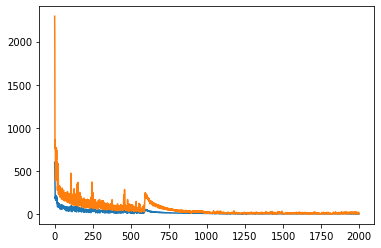

In [18]:
from matplotlib import pyplot

pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.show()

# We now get the RMSE for both train and test sets to see if they differ by much

# Make predictions based on train set and get a root mean squared error 

In [19]:
from sklearn.metrics import mean_squared_error
import math

train_yhat = cnn_model.predict(train_X)
mse = mean_squared_error(train_y, train_yhat)
rmse = math.sqrt(mse)

In [20]:
print('Train RMSE: ' + str(rmse))

Train RMSE: 7.729762839442747


# Make predictions based on test set and get a root mean squared error 

In [21]:
from sklearn.metrics import mean_squared_error
import math

test_yhat = cnn_model.predict(test_X)
mse = mean_squared_error(test_y, test_yhat)
rmse = math.sqrt(mse)

In [22]:
print('Test RMSE: ' + str(rmse))

Test RMSE: 10.204964909829318


# Plot train labels along with train predictions

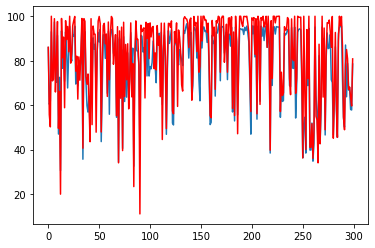

In [25]:
from matplotlib import pyplot

pyplot.plot(train_yhat, label='actual')
pyplot.plot(train_y, color='red', label='predicted')
pyplot.show()

# Plot test labels along with test predictions

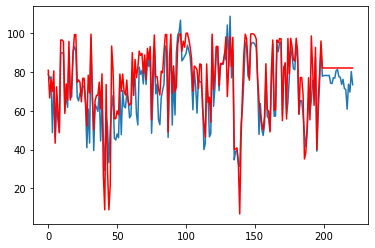

In [24]:
from matplotlib import pyplot

pyplot.plot(test_yhat, label='actual')
pyplot.plot(test_y, color='red', label='predicted')
pyplot.show()